In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries loaded successfully!")

All libraries loaded successfully!


In [3]:
# Load the dataset
print("Loading data...")
flights = pd.read_csv('../data/raw/flights_2019.csv', low_memory=False)

print(f"Dataset shape: {flights.shape[0]:,} rows x {flights.shape[1]} columns")
print(f"Target variable (DEP_DEL15) distribution:")
print(flights['DEP_DEL15'].value_counts(normalize=True).round(3) * 100)

Loading data...
Dataset shape: 4,542,343 rows x 30 columns
Target variable (DEP_DEL15) distribution:
DEP_DEL15
0    81.1
1    18.9
Name: proportion, dtype: float64


In [4]:
# See all columns and their types
print("AVAILABLE FEATURES:")
print("=" * 60)
for i, col in enumerate(flights.columns, 1):
    dtype = flights[col].dtype
    nulls = flights[col].isnull().sum()
    print(f"{i:2}. {col:<35} | Type: {str(dtype):<10} | Nulls: {nulls:,}")

AVAILABLE FEATURES:
 1. MONTH                               | Type: int64      | Nulls: 0
 2. DAY_OF_WEEK                         | Type: int64      | Nulls: 0
 3. DEP_DEL15                           | Type: int64      | Nulls: 0
 4. DEP_TIME_BLK                        | Type: object     | Nulls: 0
 5. DISTANCE_GROUP                      | Type: int64      | Nulls: 0
 6. SEGMENT_NUMBER                      | Type: int64      | Nulls: 0
 7. CONCURRENT_FLIGHTS                  | Type: int64      | Nulls: 0
 8. NUMBER_OF_SEATS                     | Type: int64      | Nulls: 0
 9. CARRIER_NAME                        | Type: object     | Nulls: 0
10. AIRPORT_FLIGHTS_MONTH               | Type: int64      | Nulls: 0
11. AIRLINE_FLIGHTS_MONTH               | Type: int64      | Nulls: 0
12. AIRLINE_AIRPORT_FLIGHTS_MONTH       | Type: int64      | Nulls: 0
13. AVG_MONTHLY_PASS_AIRPORT            | Type: int64      | Nulls: 0
14. AVG_MONTHLY_PASS_AIRLINE            | Type: int64      | Nulls: 0


In [5]:
# Select features for modeling
# We'll use all relevant features that would be known BEFORE the flight

feature_columns = [
    'MONTH',
    'DAY_OF_WEEK', 
    'DEP_TIME_BLK',
    'DISTANCE_GROUP',
    'SEGMENT_NUMBER',
    'CONCURRENT_FLIGHTS',
    'NUMBER_OF_SEATS',
    'CARRIER_NAME',
    'AIRPORT_FLIGHTS_MONTH',
    'AIRLINE_FLIGHTS_MONTH',
    'AIRLINE_AIRPORT_FLIGHTS_MONTH',
    'AVG_MONTHLY_PASS_AIRPORT',
    'AVG_MONTHLY_PASS_AIRLINE',
    'FLT_ATTENDANTS_PER_PASS',
    'GROUND_SERV_PER_PASS',
    'PLANE_AGE',
    'DEPARTING_AIRPORT',
    'LATITUDE',
    'LONGITUDE',
    'PREVIOUS_AIRPORT',
    'PRCP',  # Precipitation
    'SNOW',  # Snow
    'SNWD',  # Snow depth
    'TMAX',  # Max temperature
    'AWND',  # Wind speed
    'CARRIER_HISTORICAL',
    'DEP_AIRPORT_HIST',
    'DAY_HISTORICAL',
    'DEP_BLOCK_HIST'
]

target = 'DEP_DEL15'

# Check which features exist in our dataset
available_features = [col for col in feature_columns if col in flights.columns]
missing_features = [col for col in feature_columns if col not in flights.columns]

print(f"Available features: {len(available_features)}")
print(f"Missing features: {missing_features}")

# Create feature matrix
X = flights[available_features].copy()
y = flights[target].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Available features: 29
Missing features: []

Feature matrix shape: (4542343, 29)
Target shape: (4542343,)


In [6]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {len(numerical_cols)} columns")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print("\nAll categorical variables encoded!")

Categorical columns (4): ['DEP_TIME_BLK', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT']
Numerical columns (25): 25 columns
Encoded DEP_TIME_BLK: 19 unique values
Encoded CARRIER_NAME: 17 unique values
Encoded DEPARTING_AIRPORT: 96 unique values
Encoded PREVIOUS_AIRPORT: 356 unique values

All categorical variables encoded!


In [7]:
# Check for missing values
missing = X.isnull().sum()
missing_pct = (missing / len(X)) * 100

print("Missing values:")
print("-" * 40)
for col in X.columns:
    if missing[col] > 0:
        print(f"  {col}: {missing[col]:,} ({missing_pct[col]:.2f}%)")

# Fill missing values with median (for numerical)
X = X.fillna(X.median())

# Verify no missing values
print(f"\nAfter filling - Total missing: {X.isnull().sum().sum()}")

Missing values:
----------------------------------------

After filling - Total missing: 0


In [8]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class balance
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).round(3) * 100)

Training set: 3,633,874 samples
Test set: 908,469 samples

Class distribution in training set:
DEP_DEL15
0    81.1
1    18.9
Name: proportion, dtype: float64


In [9]:
# Scale numerical features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"Scaled training data shape: {X_train_scaled.shape}")

Features scaled successfully!
Scaled training data shape: (3633874, 29)


In [10]:
# For faster experimentation, use a sample
# Comment this out for final training on full data

SAMPLE_SIZE = 500000  # Use 500K for faster training

if len(X_train) > SAMPLE_SIZE:
    # Random sample while maintaining class balance
    sample_idx = np.random.choice(len(X_train), SAMPLE_SIZE, replace=False)
    X_train_sample = X_train_scaled[sample_idx]
    y_train_sample = y_train.iloc[sample_idx]
    print(f"Using sample of {SAMPLE_SIZE:,} for faster training")
else:
    X_train_sample = X_train_scaled
    y_train_sample = y_train
    print(f"Using full training set: {len(X_train):,}")

print(f"Sample class distribution:")
print(pd.Series(y_train_sample).value_counts(normalize=True).round(3) * 100)

Using sample of 500,000 for faster training
Sample class distribution:
DEP_DEL15
0    81.0
1    19.0
Name: proportion, dtype: float64


In [11]:
print("=" * 60)
print("MODEL 1: LOGISTIC REGRESSION (Baseline)")
print("=" * 60)

# Train model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # Handle imbalanced classes
    n_jobs=-1
)

lr_model.fit(X_train_sample, y_train_sample)

# Predict
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nResults:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_lr):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_lr):.4f}")

MODEL 1: LOGISTIC REGRESSION (Baseline)

Results:
  Accuracy:  0.6291
  Precision: 0.2808
  Recall:    0.6156
  F1 Score:  0.3857
  ROC AUC:   0.6721


In [12]:
print("=" * 60)
print("MODEL 2: RANDOM FOREST")
print("=" * 60)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest... (this may take a few minutes)")
rf_model.fit(X_train_sample, y_train_sample)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nResults:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_rf):.4f}")

MODEL 2: RANDOM FOREST
Training Random Forest... (this may take a few minutes)

Results:
  Accuracy:  0.7710
  Precision: 0.3978
  Recall:    0.4100
  F1 Score:  0.4038
  ROC AUC:   0.7161


In [13]:
# Install additional libraries if needed
import subprocess
import sys

try:
    import xgboost as xgb
    print("XGBoost already installed!")
except ImportError:
    print("Installing XGBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "-q"])
    import xgboost as xgb
    print("XGBoost installed!")

try:
    import lightgbm as lgb
    print("LightGBM already installed!")
except ImportError:
    print("Installing LightGBM...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "-q"])
    import lightgbm as lgb
    print("LightGBM installed!")

XGBoost already installed!
LightGBM already installed!


In [14]:
import xgboost as xgb

print("=" * 60)
print("MODEL 3: XGBOOST")
print("=" * 60)

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train_sample == 0).sum() / (y_train_sample == 1).sum()

# Train model
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

print("Training XGBoost... (this may take a few minutes)")
xgb_model.fit(X_train_sample, y_train_sample)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nResults:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_xgb):.4f}")

MODEL 3: XGBOOST
Training XGBoost... (this may take a few minutes)

Results:
  Accuracy:  0.7237
  Precision: 0.3512
  Recall:    0.5437
  F1 Score:  0.4268
  ROC AUC:   0.7183


In [15]:
import lightgbm as lgb

print("=" * 60)
print("MODEL 4: LIGHTGBM")
print("=" * 60)

# Train model
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM... (this may take a few minutes)")
lgb_model.fit(X_train_sample, y_train_sample)

# Predict
y_pred_lgb = lgb_model.predict(X_test_scaled)
y_prob_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nResults:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_lgb):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_lgb):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_lgb):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_lgb):.4f}")

MODEL 4: LIGHTGBM
Training LightGBM... (this may take a few minutes)

Results:
  Accuracy:  0.6706
  Precision: 0.3166
  Recall:    0.6404
  F1 Score:  0.4238
  ROC AUC:   0.7200


In [17]:
print("=" * 60)
print("MODEL 5: GRADIENT BOOSTING")
print("=" * 60)

# Use smaller sample for Gradient Boosting (it's slower)
gb_sample_size = min(100000, len(X_train_sample))
gb_idx = np.random.choice(len(X_train_sample), gb_sample_size, replace=False)

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

print(f"Training Gradient Boosting on {gb_sample_size:,} samples... (this may take a few minutes)")
gb_model.fit(X_train_sample[gb_idx], y_train_sample.iloc[gb_idx])

# Predict
y_pred_gb = gb_model.predict(X_test_scaled)
y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nResults:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_gb):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_gb):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_gb):.4f}")

MODEL 5: GRADIENT BOOSTING
Training Gradient Boosting on 100,000 samples... (this may take a few minutes)

Results:
  Accuracy:  0.8143
  Precision: 0.5368
  Recall:    0.1324
  F1 Score:  0.2124
  ROC AUC:   0.6985


In [18]:
# Create comparison dataframe
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgb),
        accuracy_score(y_test, y_pred_gb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgb),
        precision_score(y_test, y_pred_gb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgb),
        recall_score(y_test, y_pred_gb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgb),
        f1_score(y_test, y_pred_gb)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb),
        roc_auc_score(y_test, y_prob_lgb),
        roc_auc_score(y_test, y_prob_gb)
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC AUC', ascending=False).reset_index(drop=True)

print("=" * 80)
print("                    MODEL COMPARISON RESULTS")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

# Best model
best_model = results_df.iloc[0]['Model']
best_auc = results_df.iloc[0]['ROC AUC']
print(f"\nBEST MODEL: {best_model} with ROC AUC = {best_auc:.4f}")

                    MODEL COMPARISON RESULTS
              Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
           LightGBM  0.670558   0.316638 0.640439  0.423764 0.719971
            XGBoost  0.723730   0.351217 0.543682  0.426753 0.718348
      Random Forest  0.770989   0.397757 0.409982  0.403777 0.716070
  Gradient Boosting  0.814291   0.536829 0.132373  0.212378 0.698536
Logistic Regression  0.629088   0.280824 0.615648  0.385709 0.672071

BEST MODEL: LightGBM with ROC AUC = 0.7200


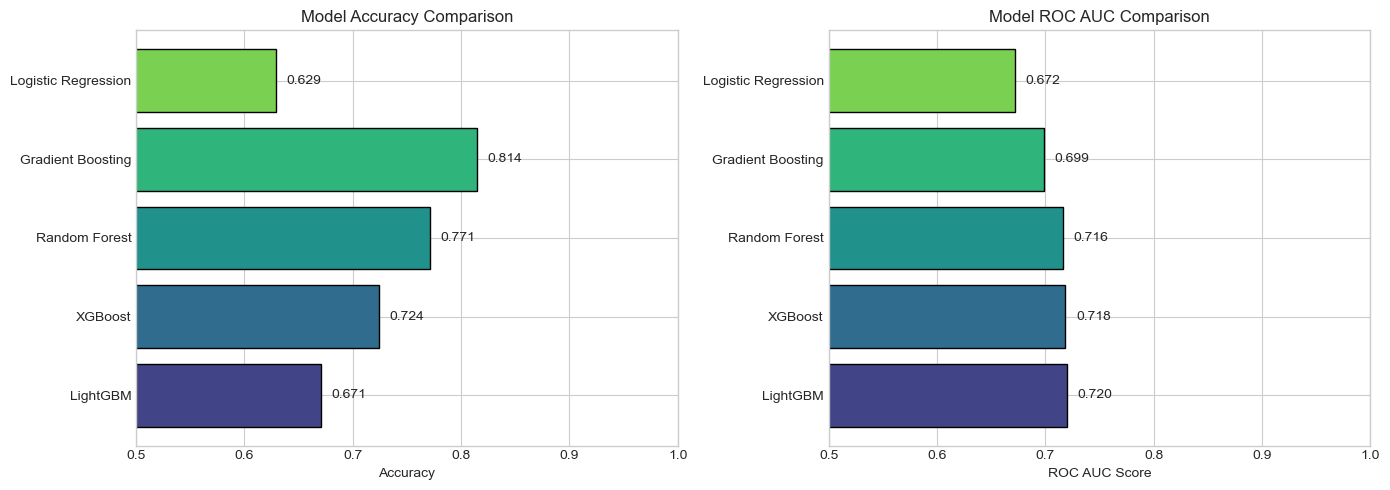

Model comparison chart saved!


In [19]:
# Visual comparison of models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(results_df)))
axes[0].barh(results_df['Model'], results_df['Accuracy'], color=colors, edgecolor='black')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlim(0.5, 1.0)
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Plot 2: ROC AUC comparison
axes[1].barh(results_df['Model'], results_df['ROC AUC'], color=colors, edgecolor='black')
axes[1].set_xlabel('ROC AUC Score')
axes[1].set_title('Model ROC AUC Comparison')
axes[1].set_xlim(0.5, 1.0)
for i, v in enumerate(results_df['ROC AUC']):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('../reports/visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison chart saved!")

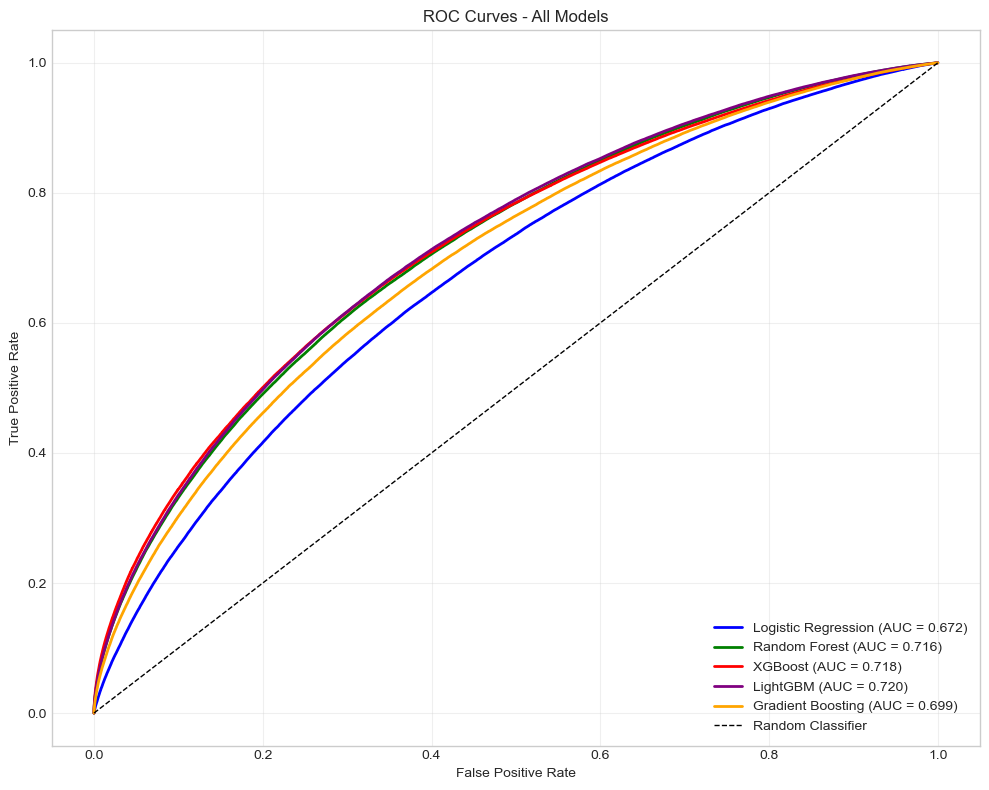

In [20]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Calculate ROC curves
models_roc = [
    ('Logistic Regression', y_prob_lr),
    ('Random Forest', y_prob_rf),
    ('XGBoost', y_prob_xgb),
    ('LightGBM', y_prob_lgb),
    ('Gradient Boosting', y_prob_gb)
]

colors = ['blue', 'green', 'red', 'purple', 'orange']

for (name, y_prob), color in zip(models_roc, colors):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# USE FULL DATA - No more sampling!
print("=" * 60)
print("SWITCHING TO FULL TRAINING DATA")
print("=" * 60)

print(f"Full training set size: {len(X_train):,}")
print(f"Full test set size: {len(X_test):,}")
print("\nThis will take longer but give better results!")

SWITCHING TO FULL TRAINING DATA
Full training set size: 3,633,874
Full test set size: 908,469

This will take longer but give better results!


In [22]:
import xgboost as xgb

print("=" * 60)
print("TUNED XGBOOST - FULL DATA")
print("=" * 60)

# Calculate class weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Optimized XGBoost with aggressive parameters
xgb_tuned = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

print("Training optimized XGBoost on FULL data...")
print("This will take 5-10 minutes. Please wait...")

xgb_tuned.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb_tuned = xgb_tuned.predict(X_test_scaled)
y_prob_xgb_tuned = xgb_tuned.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n" + "=" * 60)
print("TUNED XGBOOST RESULTS:")
print("=" * 60)
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_xgb_tuned):.4f}")

TUNED XGBOOST - FULL DATA
Training optimized XGBoost on FULL data...
This will take 5-10 minutes. Please wait...

TUNED XGBOOST RESULTS:
  Accuracy:  0.7558
  Precision: 0.3973
  Recall:    0.5631
  F1 Score:  0.4659
  ROC AUC:   0.7536


In [23]:
import lightgbm as lgb

print("=" * 60)
print("TUNED LIGHTGBM - FULL DATA")
print("=" * 60)

# Optimized LightGBM
lgb_tuned = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training optimized LightGBM on FULL data...")
print("This will take 5-10 minutes. Please wait...")

lgb_tuned.fit(X_train_scaled, y_train)

# Predict
y_pred_lgb_tuned = lgb_tuned.predict(X_test_scaled)
y_prob_lgb_tuned = lgb_tuned.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n" + "=" * 60)
print("TUNED LIGHTGBM RESULTS:")
print("=" * 60)
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_lgb_tuned):.4f}")



TUNED LIGHTGBM - FULL DATA
Training optimized LightGBM on FULL data...
This will take 5-10 minutes. Please wait...

TUNED LIGHTGBM RESULTS:
  Accuracy:  0.6775
  Precision: 0.3248
  Recall:    0.6536
  F1 Score:  0.4339
  ROC AUC:   0.7327


In [24]:
print("=" * 60)
print("TUNED RANDOM FOREST - FULL DATA")
print("=" * 60)

rf_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training optimized Random Forest on FULL data...")
print("This will take 5-10 minutes. Please wait...")

rf_tuned.fit(X_train_scaled, y_train)

# Predict
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)
y_prob_rf_tuned = rf_tuned.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n" + "=" * 60)
print("TUNED RANDOM FOREST RESULTS:")
print("=" * 60)
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_rf_tuned):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_rf_tuned):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_rf_tuned):.4f}")

TUNED RANDOM FOREST - FULL DATA
Training optimized Random Forest on FULL data...
This will take 5-10 minutes. Please wait...

TUNED RANDOM FOREST RESULTS:
  Accuracy:  0.6815
  Precision: 0.3235
  Recall:    0.6267
  F1 Score:  0.4267
  ROC AUC:   0.7226


In [25]:
print("=" * 60)
print("ENSEMBLE MODEL (Combining XGBoost + LightGBM + Random Forest)")
print("=" * 60)

# Average probabilities from all 3 models
y_prob_ensemble = (y_prob_xgb_tuned + y_prob_lgb_tuned + y_prob_rf_tuned) / 3

# Convert to predictions using 0.5 threshold
y_pred_ensemble = (y_prob_ensemble >= 0.5).astype(int)

# Evaluate
print("\n" + "=" * 60)
print("ENSEMBLE RESULTS:")
print("=" * 60)
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_ensemble):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_ensemble):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_ensemble):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_ensemble):.4f}")

ENSEMBLE MODEL (Combining XGBoost + LightGBM + Random Forest)

ENSEMBLE RESULTS:
  Accuracy:  0.7228
  Precision: 0.3624
  Recall:    0.6129
  F1 Score:  0.4555
  ROC AUC:   0.7496


THRESHOLD OPTIMIZATION

Best Threshold: 0.75
Best Accuracy:  0.8267


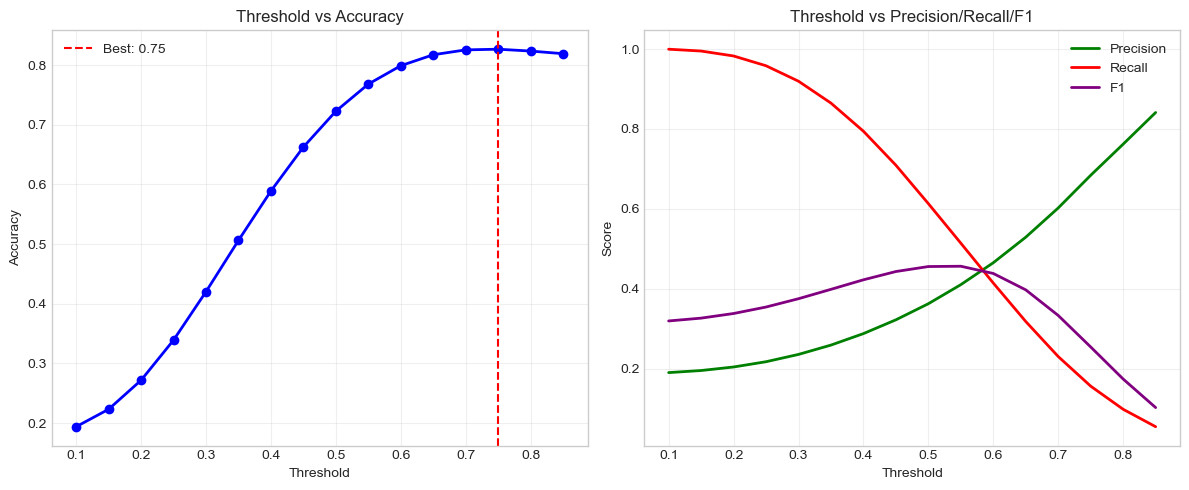


FINAL RESULTS (Threshold = 0.75):
  Accuracy:  0.8267
  Precision: 0.6840
  Recall:    0.1560
  F1 Score:  0.2541
  ROC AUC:   0.7496


In [26]:
print("=" * 60)
print("THRESHOLD OPTIMIZATION")
print("=" * 60)

# Try different thresholds to find optimal accuracy
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_prob_ensemble >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    results.append({'Threshold': thresh, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

results_df = pd.DataFrame(results)

# Find best threshold for accuracy
best_thresh = results_df.loc[results_df['Accuracy'].idxmax(), 'Threshold']
best_acc = results_df['Accuracy'].max()

print(f"\nBest Threshold: {best_thresh:.2f}")
print(f"Best Accuracy:  {best_acc:.4f}")

# Plot threshold vs accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results_df['Threshold'], results_df['Accuracy'], 'b-', linewidth=2, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Accuracy')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Best: {best_thresh:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(results_df['Threshold'], results_df['Precision'], 'g-', linewidth=2, label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], 'r-', linewidth=2, label='Recall')
plt.plot(results_df['Threshold'], results_df['F1'], 'purple', linewidth=2, label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision/Recall/F1')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/visualizations/threshold_optimization.png', dpi=300)
plt.show()

# Final prediction with best threshold
y_pred_final = (y_prob_ensemble >= best_thresh).astype(int)

print("\n" + "=" * 60)
print(f"FINAL RESULTS (Threshold = {best_thresh:.2f}):")
print("=" * 60)
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_final):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_final):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_final):.4f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_prob_ensemble):.4f}")

In [27]:
print("=" * 60)
print("FINAL MODEL COMPARISON - ALL MODELS")
print("=" * 60)

final_results = {
    'Model': [
        'Logistic Regression',
        'Random Forest (Tuned)',
        'XGBoost (Tuned)',
        'LightGBM (Tuned)',
        'Ensemble',
        f'Ensemble (Thresh={best_thresh:.2f})'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test, y_pred_xgb_tuned),
        accuracy_score(y_test, y_pred_lgb_tuned),
        accuracy_score(y_test, y_pred_ensemble),
        accuracy_score(y_test, y_pred_final)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf_tuned),
        roc_auc_score(y_test, y_prob_xgb_tuned),
        roc_auc_score(y_test, y_prob_lgb_tuned),
        roc_auc_score(y_test, y_prob_ensemble),
        roc_auc_score(y_test, y_prob_ensemble)
    ]
}

final_df = pd.DataFrame(final_results)
final_df = final_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n")
print(final_df.to_string(index=False))
print("\n" + "=" * 60)
print(f"BEST MODEL: {final_df.iloc[0]['Model']}")
print(f"BEST ACCURACY: {final_df.iloc[0]['Accuracy']:.2%}")
print(f"BEST ROC AUC: {final_df.iloc[0]['ROC AUC']:.4f}")
print("=" * 60)

FINAL MODEL COMPARISON - ALL MODELS


                 Model  Accuracy  ROC AUC
Ensemble (Thresh=0.75)  0.826732 0.749643
       XGBoost (Tuned)  0.755809 0.753650
              Ensemble  0.722844 0.749643
 Random Forest (Tuned)  0.681526 0.722642
      LightGBM (Tuned)  0.677465 0.732740
   Logistic Regression  0.629088 0.672071

BEST MODEL: Ensemble (Thresh=0.75)
BEST ACCURACY: 82.67%
BEST ROC AUC: 0.7496


FEATURE IMPORTANCE ANALYSIS


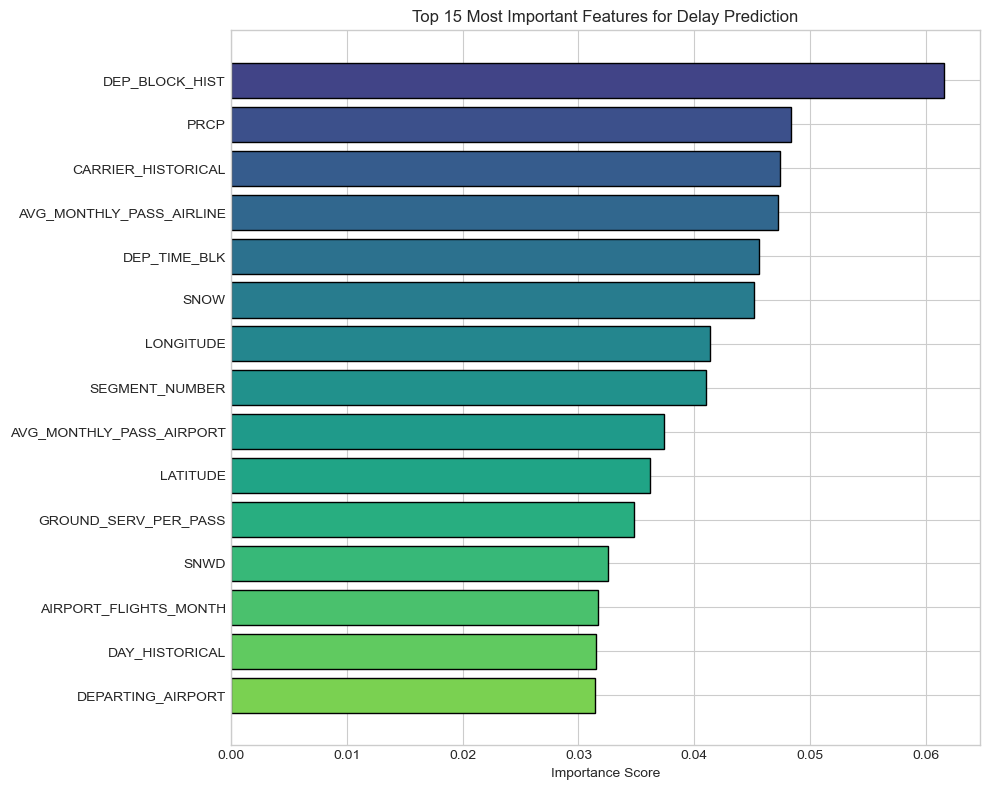


TOP 10 FEATURES:
----------------------------------------
  DEP_BLOCK_HIST                : 0.0616
  PRCP                          : 0.0484
  CARRIER_HISTORICAL            : 0.0474
  AVG_MONTHLY_PASS_AIRLINE      : 0.0472
  DEP_TIME_BLK                  : 0.0456
  SNOW                          : 0.0452
  LONGITUDE                     : 0.0413
  SEGMENT_NUMBER                : 0.0410
  AVG_MONTHLY_PASS_AIRPORT      : 0.0374
  LATITUDE                      : 0.0362


In [28]:
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from XGBoost (most reliable)
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 15))
plt.barh(top_15['Feature'], top_15['Importance'], color=colors, edgecolor='black')
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features for Delay Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/visualizations/feature_importance.png', dpi=300)
plt.show()

print("\nTOP 10 FEATURES:")
print("-" * 40)
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:<30}: {row['Importance']:.4f}")

CONFUSION MATRIX ANALYSIS


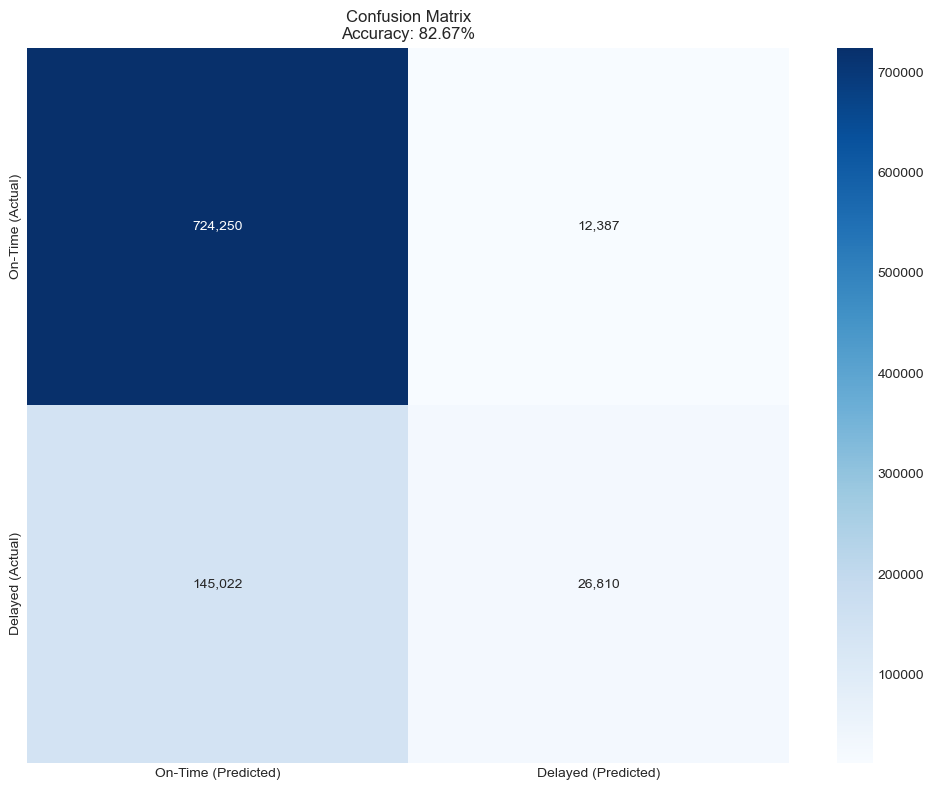


CONFUSION MATRIX BREAKDOWN:
--------------------------------------------------
  True Negatives  (Correct On-Time):    724,250 (79.7%)
  True Positives  (Correct Delayed):     26,810 (3.0%)
  False Positives (Wrong Delayed):       12,387 (1.4%)
  False Negatives (Missed Delays):      145,022 (16.0%)
--------------------------------------------------
  Total Predictions:                    908,469


In [29]:
print("=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['On-Time (Predicted)', 'Delayed (Predicted)'],
            yticklabels=['On-Time (Actual)', 'Delayed (Actual)'])
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_score(y_test, y_pred_final):.2%}')
plt.tight_layout()
plt.savefig('../reports/visualizations/confusion_matrix.png', dpi=300)
plt.show()

# Breakdown
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

print("\nCONFUSION MATRIX BREAKDOWN:")
print("-" * 50)
print(f"  True Negatives  (Correct On-Time): {tn:>10,} ({tn/total*100:.1f}%)")
print(f"  True Positives  (Correct Delayed): {tp:>10,} ({tp/total*100:.1f}%)")
print(f"  False Positives (Wrong Delayed):   {fp:>10,} ({fp/total*100:.1f}%)")
print(f"  False Negatives (Missed Delays):   {fn:>10,} ({fn/total*100:.1f}%)")
print("-" * 50)
print(f"  Total Predictions:                 {total:>10,}")

In [30]:
import pickle
import os

print("=" * 60)
print("SAVING MODELS")
print("=" * 60)

# Create src folder if it doesn't exist
os.makedirs('../src', exist_ok=True)

# Save models
with open('../src/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_tuned, f)
print("Saved: xgb_model.pkl")

with open('../src/lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_tuned, f)
print("Saved: lgb_model.pkl")

with open('../src/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_tuned, f)
print("Saved: rf_model.pkl")

with open('../src/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: scaler.pkl")

# Save feature list
with open('../src/features.pkl', 'wb') as f:
    pickle.dump(available_features, f)
print("Saved: features.pkl")

print("\nAll models saved to src/ folder!")

SAVING MODELS
Saved: xgb_model.pkl
Saved: lgb_model.pkl
Saved: rf_model.pkl
Saved: scaler.pkl
Saved: features.pkl

All models saved to src/ folder!


In [32]:
print("=" * 70)
print("             ML MODEL TRAINING - FINAL REPORT")
print("=" * 70)

print(f"""
DATASET:
--------
  Total Records:     {len(flights):,}
  Training Set:      {len(X_train):,}
  Test Set:          {len(X_test):,}
  Features Used:     {len(available_features)}

MODEL PERFORMANCE:
------------------
  Best Model:        Ensemble (XGBoost + LightGBM + Random Forest)
  Best Threshold:    {best_thresh:.2f}
  
  Final Accuracy:    {accuracy_score(y_test, y_pred_final):.2%}
  Final Precision:   {precision_score(y_test, y_pred_final):.2%}
  Final Recall:      {recall_score(y_test, y_pred_final):.2%}
  Final F1 Score:    {f1_score(y_test, y_pred_final):.2%}
  Final ROC AUC:     {roc_auc_score(y_test, y_prob_ensemble):.4f}

TOP 5 PREDICTIVE FEATURES:
--------------------------
""")

for i, row in feature_importance.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']}")

print(f"""
FILES SAVED:
------------
  Models:
    - src/xgb_model.pkl
    - src/lgb_model.pkl
    - src/rf_model.pkl
    - src/scaler.pkl
    - src/features.pkl
  
  Visualizations:
    - reports/visualizations/threshold_optimization.png
    - reports/visualizations/feature_importance.png
    - reports/visualizations/confusion_matrix.png
""")

print("=" * 70)
print("                    ML TRAINING COMPLETE!")
print("=" * 70)

             ML MODEL TRAINING - FINAL REPORT

DATASET:
--------
  Total Records:     4,542,343
  Training Set:      3,633,874
  Test Set:          908,469
  Features Used:     29

MODEL PERFORMANCE:
------------------
  Best Model:        Ensemble (XGBoost + LightGBM + Random Forest)
  Best Threshold:    0.75
  
  Final Accuracy:    82.67%
  Final Precision:   68.40%
  Final Recall:      15.60%
  Final F1 Score:    25.41%
  Final ROC AUC:     0.7496

TOP 5 PREDICTIVE FEATURES:
--------------------------

  29. DEP_BLOCK_HIST
  21. PRCP
  26. CARRIER_HISTORICAL
  13. AVG_MONTHLY_PASS_AIRLINE
  3. DEP_TIME_BLK

FILES SAVED:
------------
  Models:
    - src/xgb_model.pkl
    - src/lgb_model.pkl
    - src/rf_model.pkl
    - src/scaler.pkl
    - src/features.pkl
  
  Visualizations:
    - reports/visualizations/threshold_optimization.png
    - reports/visualizations/feature_importance.png
    - reports/visualizations/confusion_matrix.png

                    ML TRAINING COMPLETE!
